# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import models
from torch.utils.tensorboard import SummaryWriter

import os
import time
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Set Seed and Device

In [3]:
torch.manual_seed(0)
np.random.seed(0)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
device

device(type='cuda')

### Loading dataset

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Dataset/dataset_horse_vs_panda/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Dataset/dataset_horse_vs_panda/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the train and test functions

In [12]:
def test(model, data_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        accuracy = running_corrects.double() / len(data_loader.dataset)
    return accuracy

In [7]:
def log_test_images(model, test_loader, writer, epoch, device):
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            img_grid = torchvision.utils.make_grid(images.cpu())
            writer.add_image(f'Test Images/epoch_{epoch}', img_grid, epoch)
            predictions_str = " ".join([str(pred.item()) for pred in preds])
            writer.add_text(f'Predictions/epoch_{epoch}', predictions_str, epoch)


In [17]:
def train(model, train_loader, criterion, optimizer, device, num_epochs=10, model_name="model"):
    writer = SummaryWriter(log_dir=f"runs/{model_name}")

    step=0
    model.train()
    loss_history = []
    train_accuracy_hist = []
    test_accuracy_hist = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_accuracy = test(model, train_loader, criterion, device)
            test_accuracy = test(model, test_loader, criterion, device)
            writer.add_scalar("Loss/train", loss.item(), step)
            writer.add_scalar("Accuracy/train", train_accuracy, step)
            writer.add_scalar("Accuracy/test", test_accuracy, step)
            if (epoch==num_epochs):
                log_test_images(model, test_loader, writer, epoch, device)
            step += 1
        loss_history.append(running_loss / len(train_loader))
        train_accuracy_hist.append(train_accuracy)
        test_accuracy_hist.append(test_accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs} Loss: {running_loss / len(train_loader)} Training Accuracy: {train_accuracy} Test Accuracy: {test_accuracy}")
    writer.close()
    return loss_history, train_accuracy_hist, test_accuracy_hist

### Function for Plotting Results

In [9]:
def plot_data(loss):
  for i in range(len(loss[0])):
      loss[1][i] = loss[1][i].item()
      loss[2][i] = loss[2][i].item()
  plt.figure(figsize = (10,5))
  plt.subplot(1,2,1)
  plt.plot(loss[0])
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title('Loss vs Epochs')
  plt.subplot(1,2,2)
  plt.plot(loss[1], label='train')
  plt.plot(loss[2], label='test')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title('Accuracy vs Epoch')
  plt.legend()
  plt.show()

# VGG (1 Block)

### Define Model Architecture

In [18]:
class vgg_1_block(nn.Module):
    def __init__(self):
        super(vgg_1_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 112 * 112, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

vgg1b = vgg_1_block().to(device)
print(vgg1b)
num_params_vgg1b = sum(p.numel() for p in vgg1b.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params_vgg1b}')

vgg_1_block(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Number of parameters: 51381506


### Train the model

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg1b.parameters(), lr=0.001)
start_time = time.time()
vgg1b_items = train(vgg1b, train_loader, loss_fn, optimizer, device, num_epochs=10, model_name = "vgg1b")
end_time = time.time()
vgg1b_time = end_time - start_time
print(f"Training time: {vgg1b_time}")
vgg1b_test_accuracy = test(vgg1b, test_loader, loss_fn, device)
print(f"Test accuracy of VGG 1 Block = {vgg1b_test_accuracy}")
vgg1b_train_accuracy = test(vgg1b, train_loader, loss_fn, device)
print(f"Train accuracy of VGG 1 Block = {vgg1b_train_accuracy}")
torch.save(vgg1b.state_dict(), 'vgg1b.pt')

Epoch 1/10 Loss: 36.705815601348874 Training Accuracy: 0.7625000000000001 Test Accuracy: 0.675
Epoch 2/10 Loss: 6.4073793411254885 Training Accuracy: 0.8375 Test Accuracy: 0.7000000000000001
Epoch 3/10 Loss: 5.023668873310089 Training Accuracy: 0.9437500000000001 Test Accuracy: 0.75
Epoch 4/10 Loss: 0.7585530616342695 Training Accuracy: 0.9625 Test Accuracy: 0.8250000000000001
Epoch 5/10 Loss: 1.010403851023875 Training Accuracy: 0.9812500000000001 Test Accuracy: 0.8250000000000001
Epoch 6/10 Loss: 0.31349697411060334 Training Accuracy: 0.9875 Test Accuracy: 0.8250000000000001
Epoch 7/10 Loss: 0.07664954257197679 Training Accuracy: 0.95625 Test Accuracy: 0.75
Epoch 8/10 Loss: 0.22403884520740291 Training Accuracy: 1.0 Test Accuracy: 0.8250000000000001
Epoch 9/10 Loss: 0.037602495402091304 Training Accuracy: 1.0 Test Accuracy: 0.8
Epoch 10/10 Loss: 9.561210632114125e-06 Training Accuracy: 1.0 Test Accuracy: 0.8250000000000001
Training time: 66.70412063598633
Test accuracy of VGG 1 Block

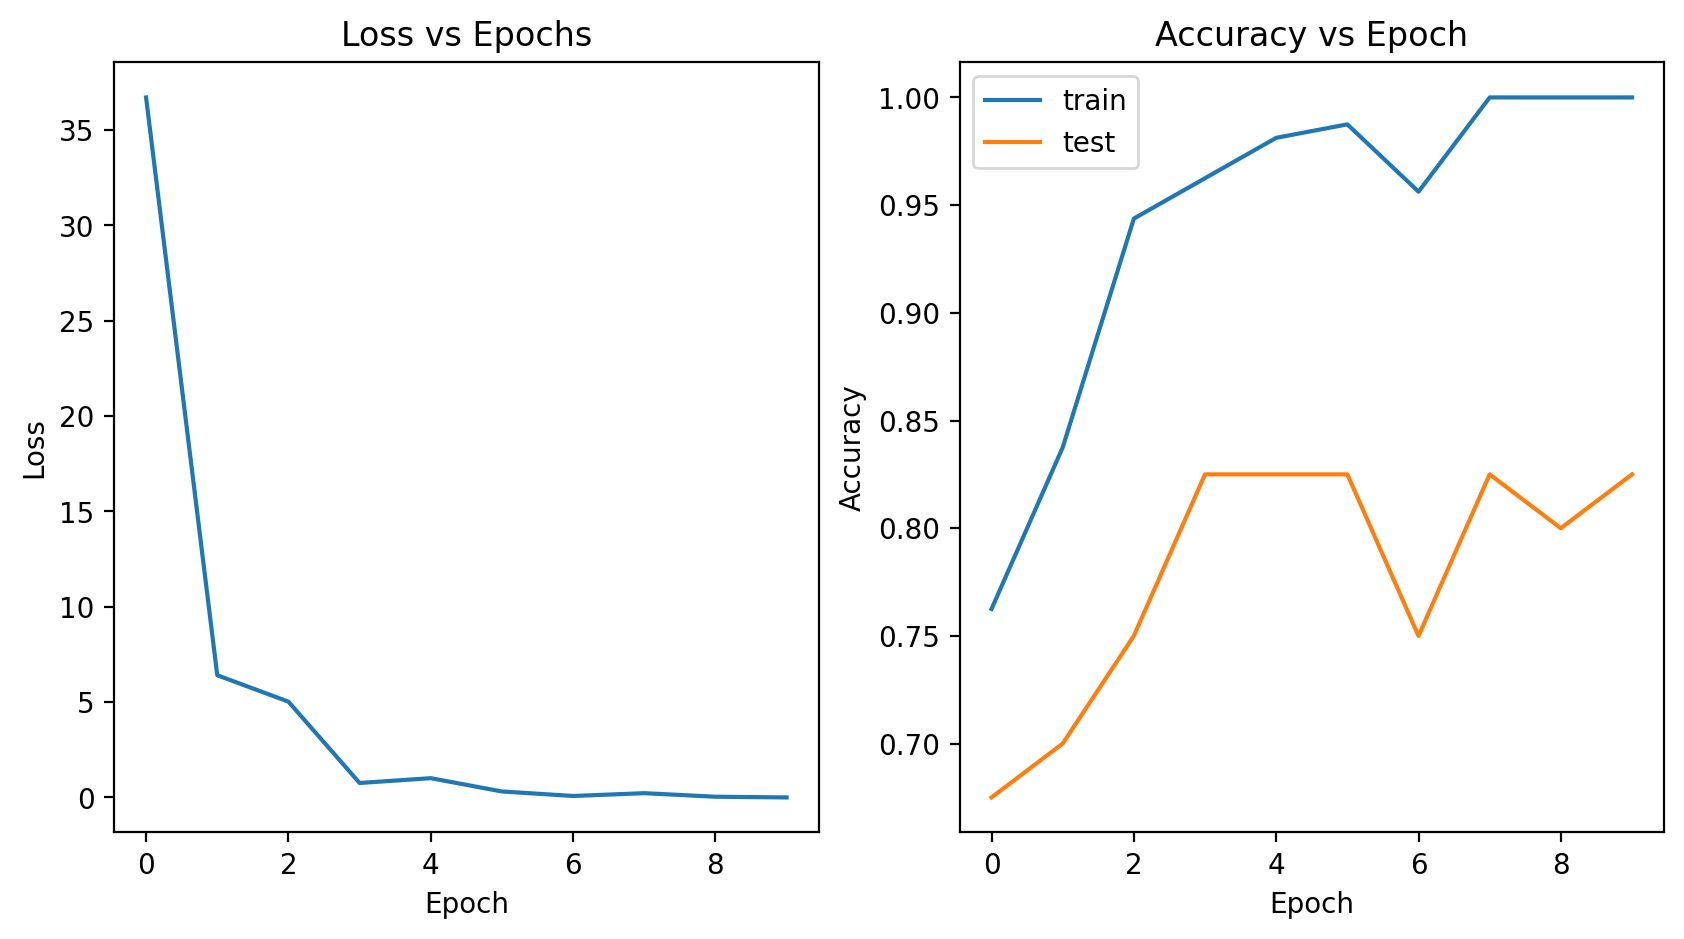

In [20]:
plot_data(vgg1b_items)

# VGG (3 Block)

### Define Model Architecture

In [21]:
class vgg_3_block(nn.Module):
    def __init__(self):
        super(vgg_3_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

vgg3b = vgg_3_block().to(device)
print(vgg3b)
print(f"Number of trainiable parameters: {sum(p.numel() for p in vgg3b.parameters() if p.requires_grad)}")

vgg_3_block(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Number of trainiable parameters: 12938690


### Train the model

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg3b.parameters(), lr=0.001)
start_time = time.time()
vgg3b_items = train(vgg3b, train_loader, loss_fn, optimizer, device, num_epochs=10, model_name = "vgg3b")
end_time = time.time()
vgg3b_time = end_time - start_time
print(f"Training time: {vgg3b_time}")
vgg3b_test_accuracy = test(vgg3b, test_loader, loss_fn, device)
print(f"Test accuracy of VGG 3 Block = {vgg3b_test_accuracy}")
vgg3b_train_accuracy = test(vgg3b, train_loader, loss_fn, device)
print(f"Train accuracy of VGG 3 Block = {vgg3b_train_accuracy}")
torch.save(vgg3b.state_dict(), 'vgg1b.pt')

Epoch 1/10 Loss: 2.854408836364746 Training Accuracy: 0.6375000000000001 Test Accuracy: 0.675
Epoch 2/10 Loss: 0.5712152004241944 Training Accuracy: 0.7312500000000001 Test Accuracy: 0.625
Epoch 3/10 Loss: 0.4858014523983002 Training Accuracy: 0.80625 Test Accuracy: 0.8
Epoch 4/10 Loss: 0.37473438382148744 Training Accuracy: 0.90625 Test Accuracy: 0.775
Epoch 5/10 Loss: 0.2325326532125473 Training Accuracy: 0.925 Test Accuracy: 0.8
Epoch 6/10 Loss: 0.15102850645780563 Training Accuracy: 0.93125 Test Accuracy: 0.8250000000000001
Epoch 7/10 Loss: 0.14471316635608672 Training Accuracy: 0.9875 Test Accuracy: 0.8500000000000001
Epoch 8/10 Loss: 0.06661008410155773 Training Accuracy: 0.9750000000000001 Test Accuracy: 0.875
Epoch 9/10 Loss: 0.05058839954435825 Training Accuracy: 1.0 Test Accuracy: 0.8250000000000001
Epoch 10/10 Loss: 0.02330785132944584 Training Accuracy: 1.0 Test Accuracy: 0.8500000000000001
Training time: 72.6794114112854
Test accuracy of VGG 3 Block = 0.8500000000000001
Tr

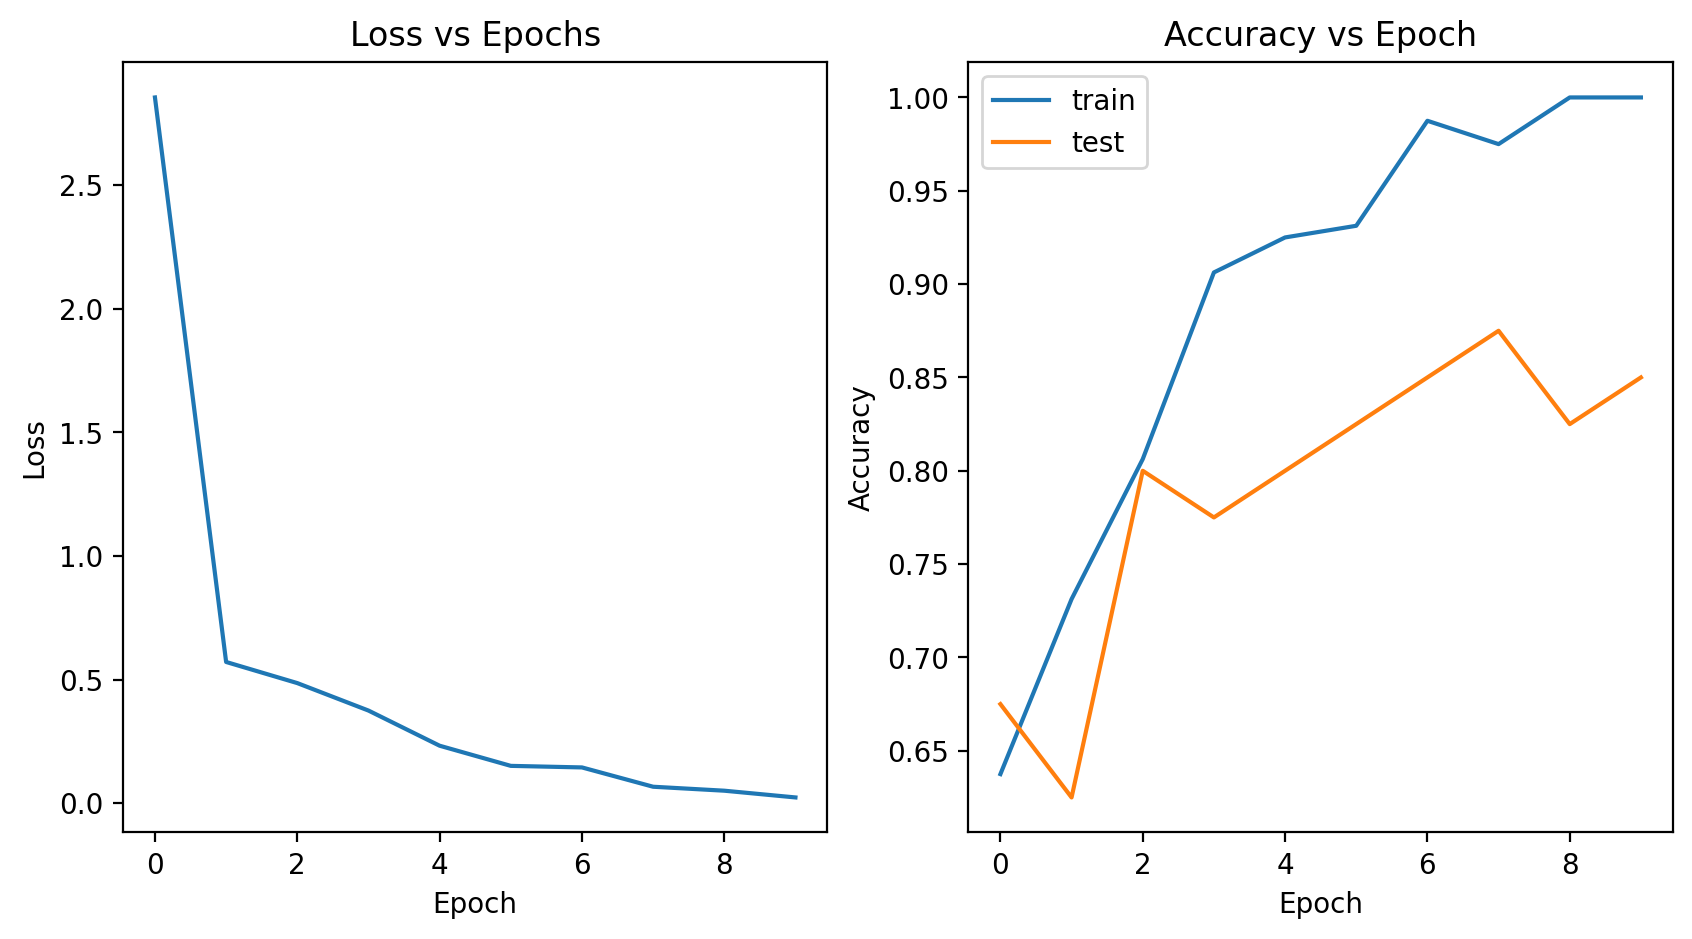

In [23]:
plot_data(vgg3b_items)

# VGG (3 Block) with Data Augmentation

### Create Data Loader with Augmentation

In [24]:
transform_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset_augmented = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Dataset/dataset_horse_vs_panda/train', transform=transform_augmented)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

vgg3b_aug = vgg_3_block().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg3b_aug.parameters(), lr=0.001)

### Training Model on Augmented Data

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg3b_aug.parameters(), lr=0.001)
start_time = time.time()
vgg3b_aug_items = train(vgg3b_aug, train_loader, loss_fn, optimizer, device, num_epochs=10, model_name = "vgg3b_aug")
end_time = time.time()
vgg3b_aug_time = end_time - start_time
print(f"Training time: {vgg3b_aug_time}")
vgg3b_aug_test_accuracy = test(vgg3b_aug, test_loader, loss_fn, device)
print(f"Test accuracy of VGG 3 Block with data augmentation = {vgg3b_aug_test_accuracy}")
vgg3b_aug_train_accuracy = test(vgg3b_aug, train_loader, loss_fn, device)
print(f"Train accuracy of VGG 3 Block with data augmentation = {vgg3b_aug_train_accuracy}")
torch.save(vgg3b_aug.state_dict(), 'vgg3b_aug.pt')

Epoch 1/10 Loss: 3.1688533782958985 Training Accuracy: 0.6687500000000001 Test Accuracy: 0.6000000000000001
Epoch 2/10 Loss: 0.6434512495994568 Training Accuracy: 0.6625000000000001 Test Accuracy: 0.47500000000000003
Epoch 3/10 Loss: 0.5210174202919007 Training Accuracy: 0.7937500000000001 Test Accuracy: 0.775
Epoch 4/10 Loss: 0.33364967703819276 Training Accuracy: 0.8562500000000001 Test Accuracy: 0.7250000000000001
Epoch 5/10 Loss: 0.2255726546049118 Training Accuracy: 0.9 Test Accuracy: 0.8250000000000001
Epoch 6/10 Loss: 0.18489379137754441 Training Accuracy: 0.9812500000000001 Test Accuracy: 0.8500000000000001
Epoch 7/10 Loss: 0.10548855587840081 Training Accuracy: 0.9875 Test Accuracy: 0.8500000000000001
Epoch 8/10 Loss: 0.07878597751259804 Training Accuracy: 0.99375 Test Accuracy: 0.9
Epoch 9/10 Loss: 0.03509223349392414 Training Accuracy: 1.0 Test Accuracy: 0.9
Epoch 10/10 Loss: 0.02192441876977682 Training Accuracy: 1.0 Test Accuracy: 0.9
Training time: 72.79175353050232
Test 

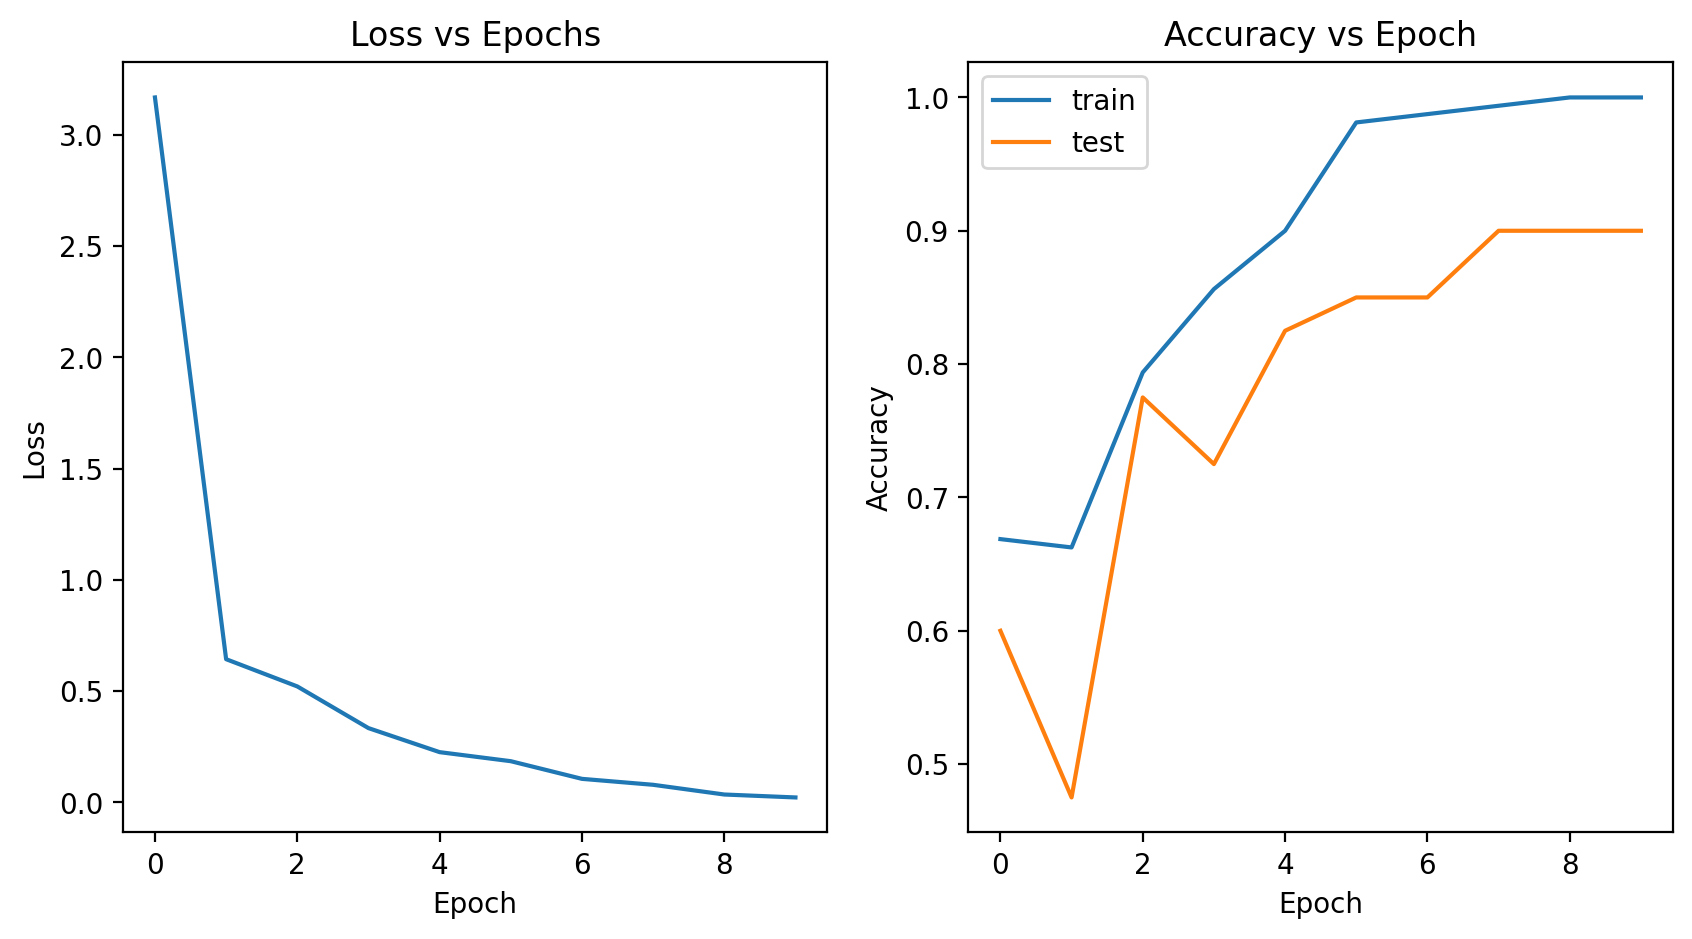

In [26]:
plot_data(vgg3b_aug_items)

# VGG 16

## VGG 16 (Fine-Tuning all layers)

### Setup the model

In [27]:
vgg16_all = models.vgg16(pretrained=True)
vgg16_all.classifier[6] = nn.Linear(4096, 2)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_all.parameters(), lr=0.001)
vgg16_all.to(device)
print(vgg16_all)
vgg16_params = sum(p.numel() for p in vgg16_all.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {vgg16_params}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 143MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_all.parameters(), lr=0.001)
start_time = time.time()
vgg16_all_items = train(vgg16_all, train_loader, loss_fn, optimizer, device, num_epochs=25, model_name = "vgg16_all")
end_time = time.time()
vgg16_all_time = end_time - start_time
print(f"Training time: {vgg16_all_time}")
vgg16_all_test_accuracy = test(vgg16_all, test_loader, loss_fn, device)
print(f"Test accuracy of VGG 16 Block with fine-tuning all layers = {vgg16_all_test_accuracy}")
vgg16_all_train_accuracy = test(vgg16_all, train_loader, loss_fn, device)
print(f"Train accuracy of VGG 16 Block with fine-tuning all layers = {vgg16_all_train_accuracy}")
torch.save(vgg16_all.state_dict(), 'vgg16_all.pt')

Epoch 1/25 Loss: 42.7006019949913 Training Accuracy: 0.5 Test Accuracy: 0.5
Epoch 2/25 Loss: 1.1842856645584106 Training Accuracy: 0.5 Test Accuracy: 0.5
Epoch 3/25 Loss: 1.289179253578186 Training Accuracy: 0.5 Test Accuracy: 0.5
Epoch 4/25 Loss: 12.673251104354858 Training Accuracy: 0.5 Test Accuracy: 0.5
Epoch 5/25 Loss: 3.848039388656616 Training Accuracy: 0.5 Test Accuracy: 0.5
Epoch 6/25 Loss: 0.7343393683433532 Training Accuracy: 0.5 Test Accuracy: 0.5
Epoch 7/25 Loss: 0.6905558347702027 Training Accuracy: 0.6937500000000001 Test Accuracy: 0.675
Epoch 8/25 Loss: 0.7223543524742126 Training Accuracy: 0.5 Test Accuracy: 0.5
Epoch 9/25 Loss: 0.6954092144966125 Training Accuracy: 0.6875 Test Accuracy: 0.7250000000000001
Epoch 10/25 Loss: 0.679206371307373 Training Accuracy: 0.70625 Test Accuracy: 0.8
Epoch 11/25 Loss: 0.5928566336631775 Training Accuracy: 0.71875 Test Accuracy: 0.7250000000000001
Epoch 12/25 Loss: 0.5701894760131836 Training Accuracy: 0.74375 Test Accuracy: 0.65
Epo

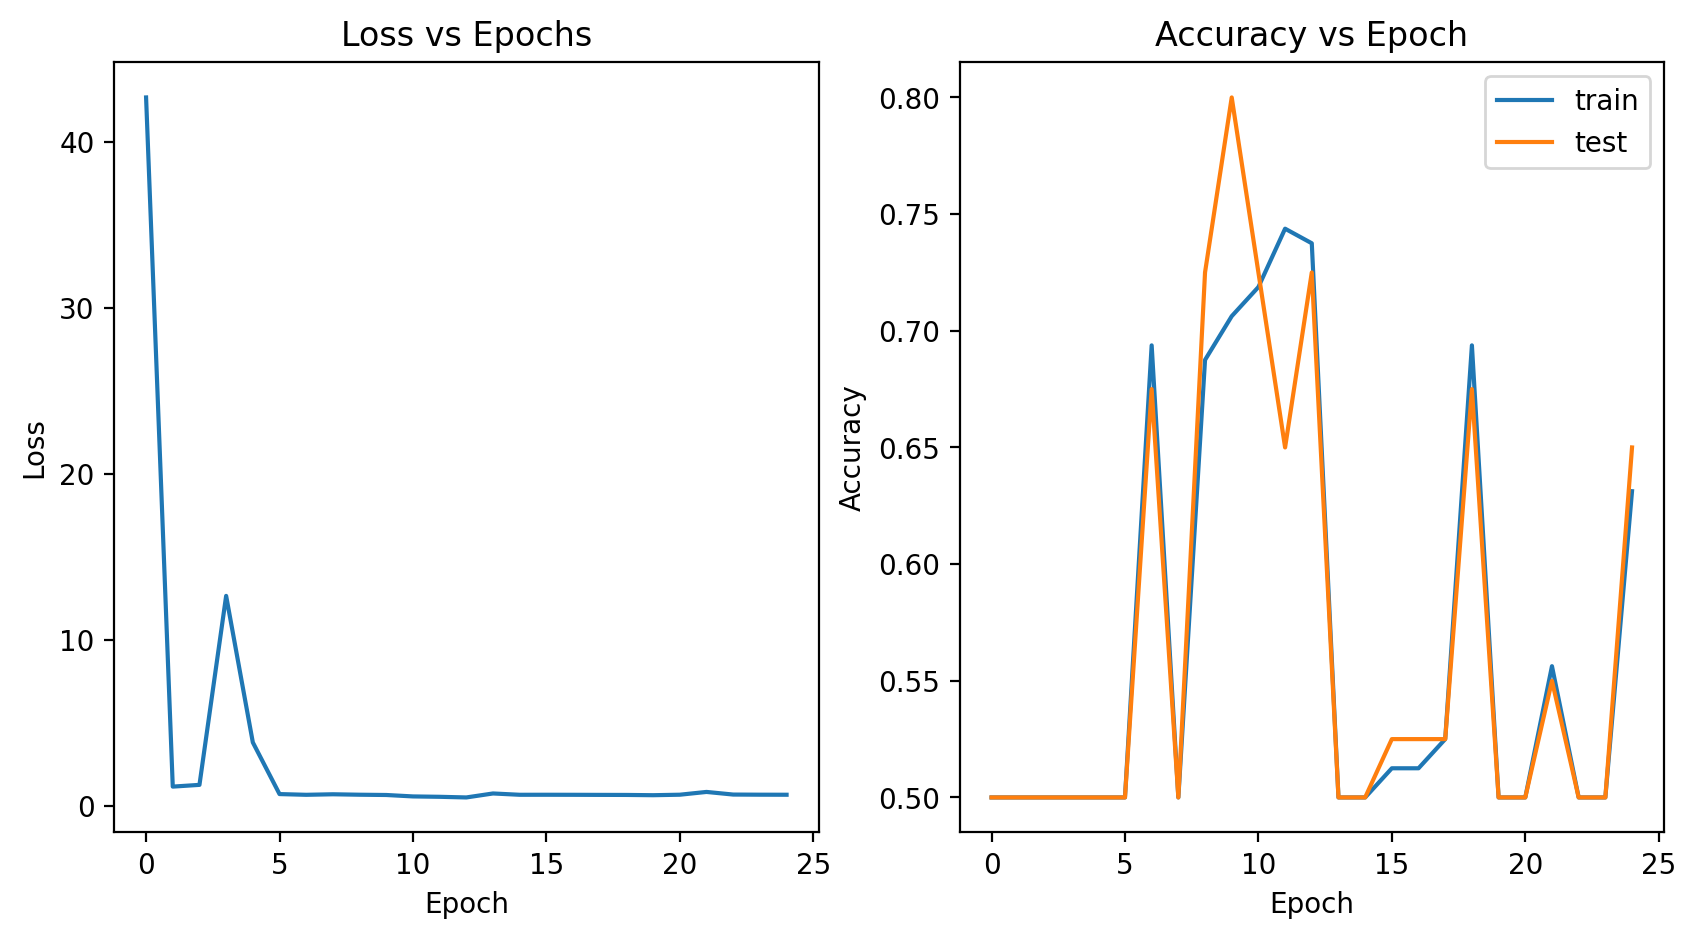

In [29]:
plot_data(vgg16_all_items)

## VGG (16 Block) with Fine-Tuning only Final Layer

### Setup the model

In [30]:
vgg16_final = models.vgg16(pretrained=True)
for param in vgg16_final.parameters():
    param.requires_grad = False
vgg16_final.classifier[6] = nn.Linear(4096, 2)
for param in vgg16_final.classifier[6].parameters():
    param.requires_grad = True
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_final.parameters(), lr=0.001)
vgg16_final.to(device)
print(vgg16_final)
vgg16_params = sum(p.numel() for p in vgg16_final.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {vgg16_params}")

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_final.parameters(), lr=0.001)
start_time = time.time()
vgg16_final_items = train(vgg16_final, train_loader, loss_fn, optimizer, device, num_epochs=1, model_name = "vgg16_final")
end_time = time.time()
vgg16_final_time = end_time - start_time
print(f"Training time: {vgg16_final_time}")
vgg16_final_test_accuracy = test(vgg16_final, test_loader, loss_fn, device)
print(f"Test accuracy of VGG 16 Block with fine-tuning only final layers = {vgg16_final_test_accuracy}")
vgg16_final_train_accuracy = test(vgg16_final, train_loader, loss_fn, device)
print(f"Train accuracy of VGG 16 Block with fine-tuning only final layers = {vgg16_final_train_accuracy}")
torch.save(vgg16_final.state_dict(), 'vgg16_final.pt')

Epoch 1/1 Loss: 0.24668943956494332 Training Accuracy: 1.0 Test Accuracy: 1.0
Training time: 11.80798888206482
Test accuracy of VGG 16 Block with fine-tuning only final layers = 1.0
Train accuracy of VGG 16 Block with fine-tuning only final layers = 1.0


# Comparing different models

### Training Time

In [32]:
print("Training time for VGG 1:", vgg1b_time)
print("Training time for VGG 3:", vgg3b_time)
print("Training time for VGG 3 with Augmentation:", vgg3b_aug_time)
print("Training time for VGG 16 (Fine-Tuning all layers):", vgg16_all_time)
print("Training time for VGG 16 (Fine-Tuning final layer):", vgg16_final_time)

Training time for VGG 1: 66.70412063598633
Training time for VGG 3: 72.6794114112854
Training time for VGG 3 with Augmentation: 72.79175353050232
Training time for VGG 16 (Fine-Tuning all layers): 327.3699164390564
Training time for VGG 16 (Fine-Tuning final layer): 11.80798888206482


### Training Accuracy

In [33]:
print("Training Accuracy for VGG 1:", vgg1b_train_accuracy)
print("Training Accuracy for VGG 3:", vgg3b_train_accuracy)
print("Training Accuracy for VGG 3 with Augmentation:", vgg3b_aug_train_accuracy)
print("Training Accuracy for VGG 16 (Fine-Tuning all layers):", vgg16_all_train_accuracy)
print("Training Accuracy for VGG 16 (Fine-Tuning final layer):", vgg16_final_train_accuracy)

Training Accuracy for VGG 1: tensor(1., device='cuda:0', dtype=torch.float64)
Training Accuracy for VGG 3: tensor(1., device='cuda:0', dtype=torch.float64)
Training Accuracy for VGG 3 with Augmentation: tensor(1., device='cuda:0', dtype=torch.float64)
Training Accuracy for VGG 16 (Fine-Tuning all layers): tensor(0.6313, device='cuda:0', dtype=torch.float64)
Training Accuracy for VGG 16 (Fine-Tuning final layer): tensor(1., device='cuda:0', dtype=torch.float64)


### Test Accuracy

In [34]:
print("Test Accuracy for VGG 1:", vgg1b_test_accuracy)
print("Test Accuracy for VGG 3:", vgg3b_test_accuracy)
print("Test Accuracy for VGG 3 with Augmentation:", vgg3b_aug_test_accuracy)
print("Test Accuracy for VGG 16 (Fine-Tuning all layers):", vgg16_all_test_accuracy)
print("Test Accuracy for VGG 16 (Fine-Tuning final layer):", vgg16_final_test_accuracy)

Test Accuracy for VGG 1: tensor(0.8250, device='cuda:0', dtype=torch.float64)
Test Accuracy for VGG 3: tensor(0.8500, device='cuda:0', dtype=torch.float64)
Test Accuracy for VGG 3 with Augmentation: tensor(0.9000, device='cuda:0', dtype=torch.float64)
Test Accuracy for VGG 16 (Fine-Tuning all layers): tensor(0.6500, device='cuda:0', dtype=torch.float64)
Test Accuracy for VGG 16 (Fine-Tuning final layer): tensor(1., device='cuda:0', dtype=torch.float64)


### Training Loss

In [35]:
print("Training Loss for VGG 1:", vgg1b_items[0][-1])
print("Training Loss for VGG 3:", vgg3b_items[0][-1])
print("Training Loss for VGG 3 with Augmentation:", vgg3b_aug_items[0][-1])
print("Training Loss for VGG 16 (Fine-Tuning all layers):", vgg16_all_items[0][-1])
print("Training Loss for VGG 16 (Fine-Tuning final layer):", vgg16_final_items[0][-1])

Training Loss for VGG 1: 9.561210632114125e-06
Training Loss for VGG 3: 0.02330785132944584
Training Loss for VGG 3 with Augmentation: 0.02192441876977682
Training Loss for VGG 16 (Fine-Tuning all layers): 0.6940552234649658
Training Loss for VGG 16 (Fine-Tuning final layer): 0.24668943956494332


### Number of Parameters

In [36]:
print("Number of parameters in VGG 1:", sum(p.numel() for p in vgg1b.parameters() if p.requires_grad))
print("Number of parameters in VGG 3:", sum(p.numel() for p in vgg3b.parameters() if p.requires_grad))
print("Number of parameters in VGG 3 with Augmentation:", sum(p.numel() for p in vgg3b_aug.parameters() if p.requires_grad))
print("Number of parameters in VGG 16 (Fine-Tuning all layers):", sum(p.numel() for p in vgg16_all.parameters() if p.requires_grad))
print("Number of parameters in VGG 16 (Fine-Tuning final layer):", sum(p.numel() for p in vgg16_final.parameters() if p.requires_grad))

Number of parameters in VGG 1: 51381506
Number of parameters in VGG 3: 12938690
Number of parameters in VGG 3 with Augmentation: 12938690
Number of parameters in VGG 16 (Fine-Tuning all layers): 134268738
Number of parameters in VGG 16 (Fine-Tuning final layer): 8194


# Tabular Statistics
| Model            | Training Time (in sec) | Training Loss | Training Accuracy | Testing Accuracy | Number of Model Parameters |
|------------------|---------------|---------------|-------------------|------------------|----------------------------|
| VGG (1 Block)          |    66.70          |  0.000009561210632114125             |     1.0              |    0.8250              |  51381506                          |
| VGG (3 Block)          |    72.67           |   0.02330785132944584            |    1.0               |   0.8750               |                    12938690        |
| VGG (3 Block) with Augmentation         |    72.79           |       0.02192441876977682        |    1.0               |     0.9000             |        12938690                    |
| VGG16 (Fine-Tuning all Layers)          |    327.36           |        0.6940552234649658       |      0.6313             |   0.6500               |              134268738              |
| VGG16 (Fine-Tuning final layer)          |     11.80          |      0.24668943956494332        |      1.0             |  1.0                |                     8194       |


- Are the results as expected? Why or why not?<br>
-> Yes, the results are as expected i.e. as we increase the model complexity we are getting better accuracy on the test data. Moreover, training time also increase as the complexity of the model increase. There is only 1 exception about fine-tuning all layers of vgg16 for which we get the least accuracy both in training and testing. This may be as it is a ery large model, it may be overfitting the data and not giving expected results.<br><br>
- Does data augmentation help? Why or why not?<br>
-> Yes, data augmentation helps in increasing model preformance as model see new differently oriented images. So, it can generalise better.<br><br>
- Does it matter how many epochs you fine-tune the model? Why or why not?<br>
-> For fine-tuning whole, the number of epochs matter as the model complexity is very high. But for fine-tuning oly the final layer, we can get good results in less epochs also.<br><br>
- Are there any particular images that the model is confused about? Why or why not?<br>
Yes, the images where the background of the images is similar to the other class or where the main object is not completely visible, it may be classified incorrectly.

In [54]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(224*224*3, 2048)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(2048, 1024)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(1024, 1000)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(1000, 2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

mlp = MLP().to(device)
print(mlp)
print(f"Number of trainable parameters: {sum(p.numel() for p in mlp.parameters() if p.requires_grad)}")


MLP(
  (fc1): Linear(in_features=150528, out_features=2048, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=1024, out_features=1000, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=1000, out_features=2, bias=True)
)
Number of trainable parameters: 311408570


In [55]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
start_time = time.time()
mlp_items = train(mlp, train_loader, loss_fn, optimizer, device, num_epochs=10, model_name = "mlp")
end_time = time.time()
mlp_time = end_time - start_time
print(f"Training time: {mlp_time}")
mlp_test_accuracy = test(mlp, test_loader, loss_fn, device)
print(f"Test accuracy of MLP = {mlp_test_accuracy}")
mlp_train_accuracy = test(mlp, train_loader, loss_fn, device)
print(f"Train accuracy of MLP = {mlp_train_accuracy}")
torch.save(mlp.state_dict(), 'mlp.pt')

Epoch 1/10 Loss: 14.148894608020782 Training Accuracy: 0.6000000000000001 Test Accuracy: 0.5750000000000001
Epoch 2/10 Loss: 2.6202272534370423 Training Accuracy: 0.86875 Test Accuracy: 0.775
Epoch 3/10 Loss: 0.8985718458890914 Training Accuracy: 0.9125000000000001 Test Accuracy: 0.775
Epoch 4/10 Loss: 0.8409863322973251 Training Accuracy: 0.95625 Test Accuracy: 0.75
Epoch 5/10 Loss: 0.2874776036478579 Training Accuracy: 0.925 Test Accuracy: 0.7250000000000001
Epoch 6/10 Loss: 0.6313084788620472 Training Accuracy: 0.9875 Test Accuracy: 0.775
Epoch 7/10 Loss: 0.07953344001434744 Training Accuracy: 0.99375 Test Accuracy: 0.775
Epoch 8/10 Loss: 0.008618661004584282 Training Accuracy: 0.9875 Test Accuracy: 0.775
Epoch 9/10 Loss: 0.017626477222074756 Training Accuracy: 0.9812500000000001 Test Accuracy: 0.775
Epoch 10/10 Loss: 0.06666219720209483 Training Accuracy: 0.99375 Test Accuracy: 0.75
Training time: 68.82343029975891
Test accuracy of MLP = 0.75
Train accuracy of MLP = 0.99375


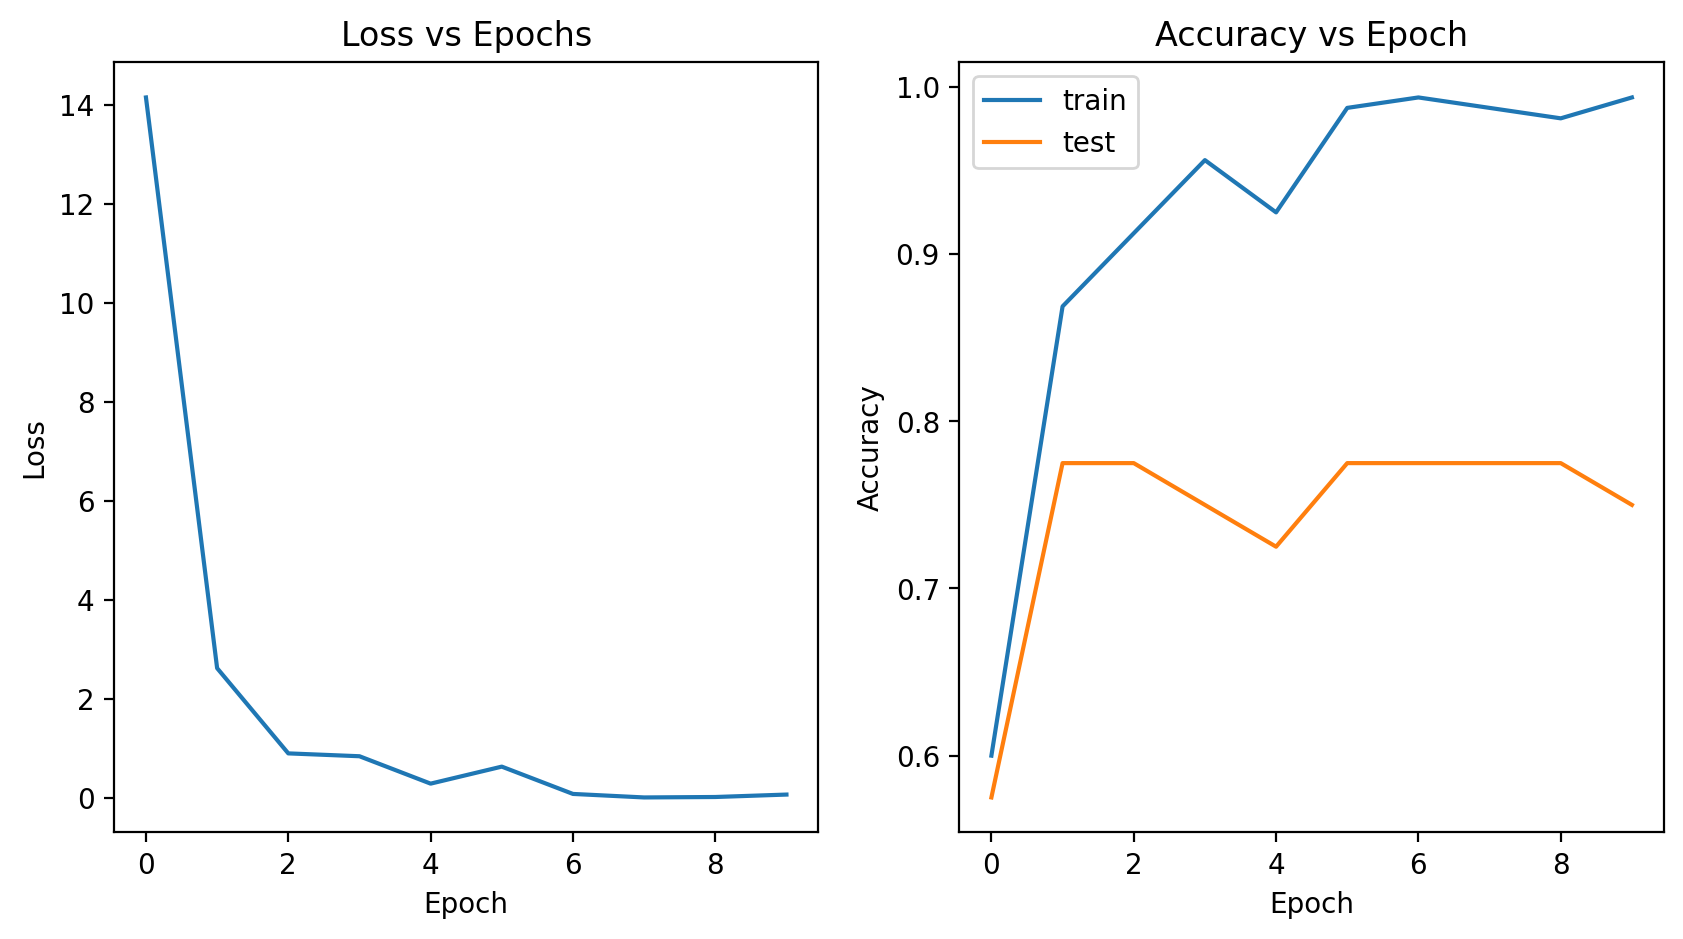

In [56]:
plot_data(mlp_items)

The MLP of the model complexity comparable to VGG16 gives worse results than even the VGG 1 Block. This may be because, the mlp cannot identify spatial features of the image and hence cannot classify all the images correctly.
